# CNN Creating and evaluation for the Fer-2013 model
### This notebook was used in google collab using their free gpu runtime, it has copied over to here


### Step 1 - load the training and testing data from the csv

In [ ]:
#the coordinate csvs are saved into google drive so google collab can use them
from google.colab import drive
drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np

training_data = pd.read_csv('drive/MyDrive/face_landmarks_train.csv')
test_data = pd.read_csv('drive/MyDrive/face_landmarks_test.csv')

valid_emotions = ['happy', 'sad', 'neutral', 'angry']

training_data = training_data[training_data['label'].isin(valid_emotions)]
test_data = test_data[test_data['label'].isin(valid_emotions)]

x_train = training_data.iloc[:, 1:]
y_train = training_data['label']

x_test = test_data.iloc[:, 1:]
y_test = test_data['label']

print(x_train.shape)
print(x_test.shape)

(17558, 1434)
(4372, 1434)


### Step 2 - Reshape data and apply one hot encoding to y values

In [3]:
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

x_train_array = x_train.values
x_train_reshaped = x_train_array.reshape((x_train.shape[0], 478, 3))

x_test_array = x_test.values
x_test_reshaped = x_test_array.reshape((x_test.shape[0], 478, 3))

print(x_train_reshaped.shape)
print(x_test_reshaped.shape)

onehot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
y_train_encode = onehot_encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encode = onehot_encoder.transform(y_test.values.reshape(-1, 1))

print(y_train_encode.shape)
print(y_train_encode)

(17558, 478, 3)
(4372, 478, 3)
(17558, 4)
[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 0. 0. 0.]]


### Step 3 - Train the model

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, Dropout, BatchNormalization

In [5]:
import time
from tensorflow.keras.callbacks import TensorBoard

model = Sequential()

model.add(Conv1D(256, kernel_size=3, input_shape = (478,3), activation='relu'))
model.add(MaxPooling1D(pool_size=2))


model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
#model.add(BatchNormalization())

model.add(Conv1D(256, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.summary()

name = "{}".format( int(time.time()))
tensorboard = TensorBoard(log_dir="logs/{}".format(name))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

history = model.fit(x_train_reshaped, y_train_encode, epochs=50, validation_data=(x_test_reshaped, y_test_encode), callbacks=[tensorboard])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 476, 256)          2560      
                                                                 
 max_pooling1d (MaxPooling1  (None, 238, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 236, 256)          196864    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 118, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 116, 256)          196864    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 58, 256)           0

In [ ]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs/

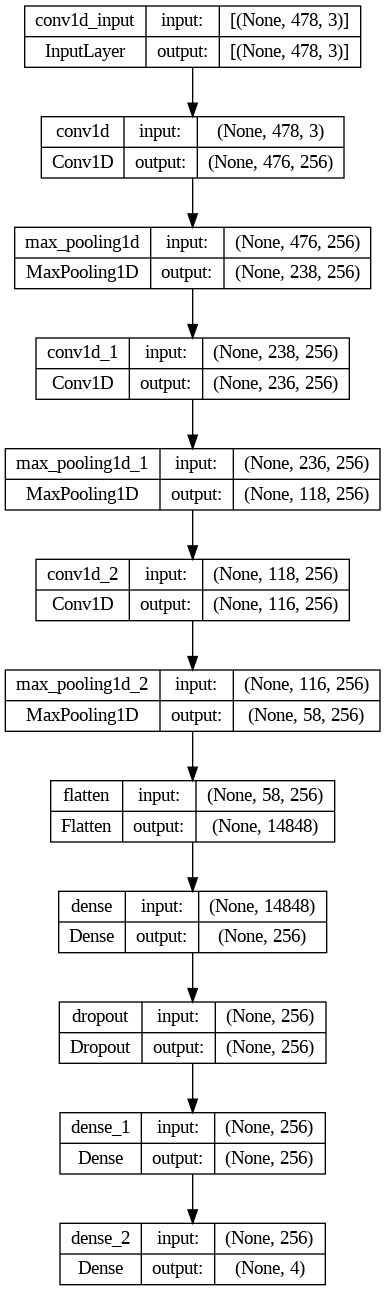

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

### Step 4 - Evaluate

### Training graph

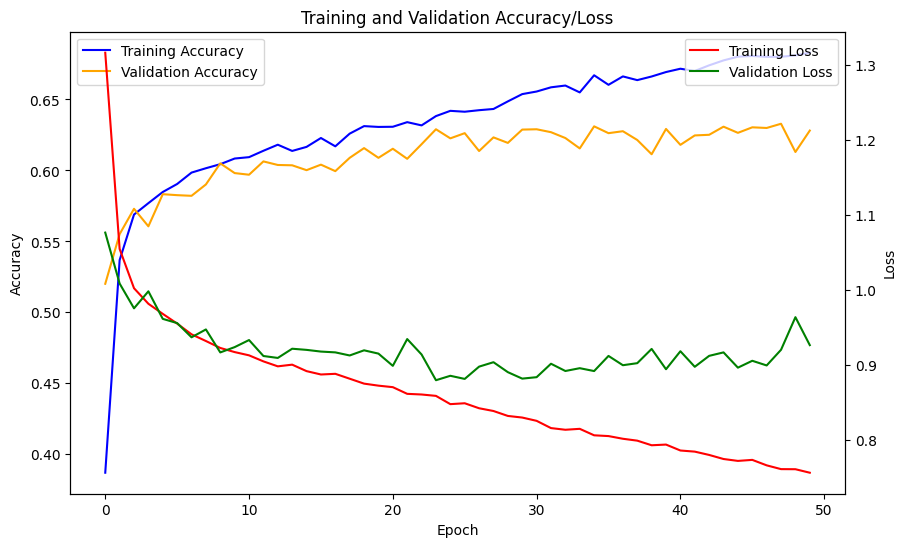

In [9]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(history.history['categorical_accuracy'], label='Training Accuracy', color='blue')
ax1.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy', color='orange')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.tick_params(axis='y')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()

ax2.plot(history.history['loss'], label='Training Loss', color='red')
ax2.plot(history.history['val_loss'], label='Validation Loss', color='green')
ax2.set_ylabel('Loss')
ax2.tick_params(axis='y')
ax2.legend(loc='upper right')

plt.title('Training and Validation Accuracy/Loss')
plt.show()

In [10]:
val_loss, val_acc = model.evaluate(x_test_reshaped, y_test_encode)

137/137 [==============================] - 1s 6ms/step - loss: 0.9259 - categorical_accuracy: 0.6281


In [11]:
model.save('emotion_detection_model-fer2013-63.keras')

### Confusion Matrix

In [29]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

y_pred_prob = model.predict(x_test_reshaped)

y_pred = np.argmax(y_pred_prob, axis=1)

y_test = np.argmax(y_test_encode, axis=1)

cm = confusion_matrix(y_test, y_pred)

137/137 [==============================] - 1s 4ms/step


In [23]:
#This code has been taken from the sklearn website for creating a confusion matrix

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [26]:
cm_plot_labels = ['angry', 'happy', 'neutral', 'sad']

Confusion matrix, without normalization
[[ 342  122  241   88]
 [  42 1351  132   36]
 [  84  108  785   90]
 [ 149  138  396  268]]


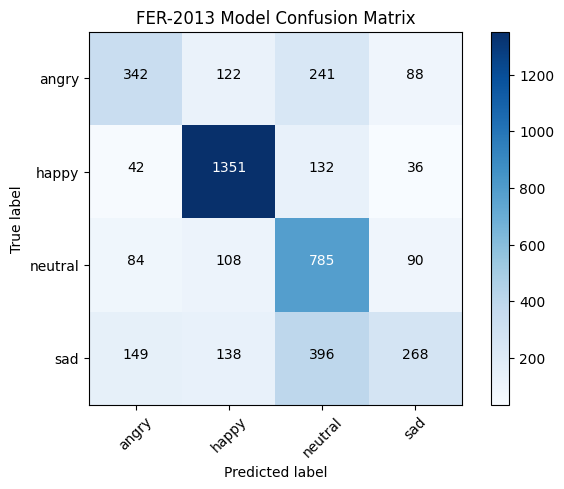

In [28]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='FER-2013 Model Confusion Matrix')

### Classification report

In [31]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.43      0.49       793
           1       0.79      0.87      0.82      1561
           2       0.51      0.74      0.60      1067
           3       0.56      0.28      0.37       951

    accuracy                           0.63      4372
   macro avg       0.60      0.58      0.57      4372
weighted avg       0.63      0.63      0.61      4372

